# Projeto NLP - Detectando Fake News (Noticias falsas)
Nesse projeto são apresentadas diferentes abordagens para detecção de noticias falsas.

# Motivação

No atual cenário de grande avanço tecnológico e uso das redes sociais em todas as camadas e classes sociais uma situação que causa problemas gráves é a divulgação de notícias falsas, pois essas podem prejucar a reputação de pessoas e organizações, e em casos mais gráves levar a linchamentos públicos.
Diante deste cenário, é de extrema importancia o desenvolvimento de métodos que consigam identificar possíveis noticias falsas para que seja possível tirá-las do ar.

Instalação das bibliotecas utilizadas

In [83]:
# !pip install -U scikit-learn
# !pip install pandas seaborn
# !pip install simpletransformers
# !pip install nltk

Importação das bibliotecas utilizaddas

In [100]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import json

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

Configuração de display da biblioteca pandas

In [85]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x:'%.2f' %x)

# Lendo dados da base de dados 
<b>local de download:</b> Hugging faceFace

<b>url:</b> https://huggingface.co/datasets/mrm8488/fake-news

In [86]:
# Lendo os dados:
with open('fake_news_data_set.json') as file:
    data_set_json = json.load(file)

# Use pd.json_normalize to convert the JSON to a DataFrame
df_news = pd.json_normalize(data_set_json['rows'], 
                     meta=[['row', 'text'], ['row', 'label']])

df_news.columns = ['index', '.', 'text', 'label']
df_news['label'] = [int(label) for label in df_news['label']]
df_news = df_news.drop(['.'], axis=1)
df_news = df_news.set_index('index')

df_news.head()

,text,label
index,,
0,The Trump administration has been getting abso...,1
1,NAIROBI (Reuters) - Kenyan police shot dead tw...,0
2,PC is killing our country. This is called figh...,1
3,WASHINGTON (Reuters) - Republicans are poised ...,0
4,(Reuters) - A U.S. appeals court ruled on Frid...,0


In [87]:
# Detalhes da base
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    100 non-null    object
 1   label   100 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.3+ KB


In [88]:
# Colunas da base de dados
df_news.columns

Index(['text', 'label'], dtype='object')

In [89]:
# Validando a existência de dados nulos, no caso não existe
df_news.isnull().sum()

text     0
label    0
dtype: int64

In [90]:
# Rótulos dos dados 0 - Notícia Real, 1 - Notícia falsa
df_news['label'].unique()

array([1, 0])

<Axes: xlabel='label', ylabel='count'>

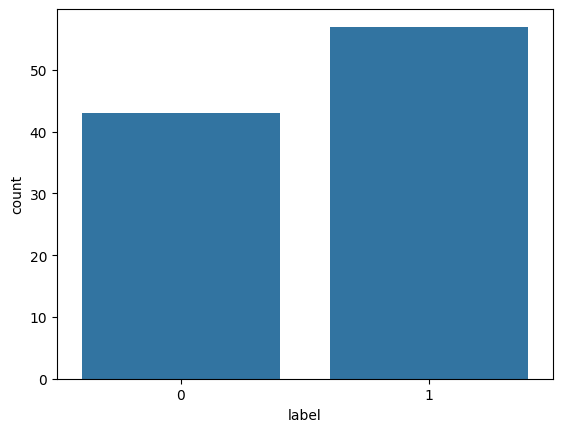

In [91]:
# Distribuição de positivos e negativos
sns.countplot(data=df_news, x='label')

# Preparando base para treinamento dos modelos
Separação em features e target

In [92]:
# Separando as features X e Y, treianemnto e teste
X = df_news['text']
Y = df_news['label']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=42)

# Tokenization
Criando uma representação para o texto por meio de p método TFiDF

In [93]:
# Download de stopwords para limpeza de ruidos
nltk.download('stopwords')
sw_en = nltk.corpus.stopwords.words('english')
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=sw_en)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/williansmagalhaesprimo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [94]:
# Aplicando a tokenização na base de treinamento
X_train = vectorizer.fit_transform(X_train)
X_train.shape

(80, 2058)

# Modelo de NLP 01 - SVC
Nessa primeira abordagem será usado o SVC <b>Modelo de Linear Support Vector Classifier</b>.
Uma versão do SVN - Suport Vector Machine aplicado em tarefas de classificação

In [95]:
# Criação do modelo SVC:
svc = LinearSVC()
svc.fit(X_train, y_train)

/Users/williansmagalhaesprimo/Library/Python/3.8/lib/python/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

In [96]:
# Aplicando a tokenização na base de treinamento
X_test = vectorizer.transform(X_test)
X_test.shape

(20, 2058)

Testes e Métricas para o modelo SVC

In [97]:
# Teste do modelo SVC
prediction = svc.predict(X_test)

# Verificando acurácia do modelo SVC
accuracy = accuracy_score(y_test, prediction)
print("Accuracy:", accuracy)

Accuracy: 0.75


In [82]:
# Métricas para o modelo SVC (scores)
print(metrics.classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.67      0.75      0.71         8
           1       0.82      0.75      0.78        12

    accuracy                           0.75        20
   macro avg       0.74      0.75      0.74        20
weighted avg       0.76      0.75      0.75        20

[[6 2]
 [3 9]]


<Axes: >

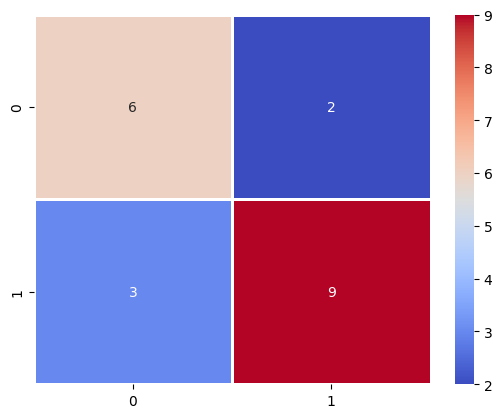

In [102]:
# Matriz de confusão
matriz_svc = metrics.confusion_matrix(y_test, prediction)
sns.heatmap(matriz_svc, cmap='coolwarm', annot=True, linewidth=1, fmt='d')